# Risk Premia in REITs and its application in a quantitative value strategy

##### Dissertation for Master's degree in Economics from [Insper](https://www.insper.edu.br/en/graduate/masters-of-science/)

##### Advisor: [Prof. Dr. Gustavo B. Soares](https://github.com/gustavobsoares/) ([CV](http://lattes.cnpq.br/8491228979459078))
##### Student: Lucas L. Sanches ([Resume](http://lattes.cnpq.br/2528322802099316))

# Brazil Notebook

### Imports

In [1]:
from utils.database import *

In [2]:
from statsmodels.regression.rolling import RollingOLS
from linearmodels import LinearFactorModelGMM
from tqdm import tqdm
import statsmodels.api as sm
import scipy.stats as stats
import talib as ta
import matplotlib.pyplot as plt
%matplotlib inline

### Brazil Regressions

In [3]:
# statistics of monthly data
brazil_xs = ['IBOV Index (ER)','IFIX Index (ER)','BZAD10Y Index (ER)']
df_brazil = pd.read_excel('data/data.xlsx', sheet_name='total_return', index_col=0)[brazil_xs].loc[bz_factors.index]
df_brazil = np.log(df_brazil.resample('M').last()).diff().dropna()

placeholders = list(range(len(brazil_xs)))
summary_statistics_bz = pd.DataFrame({'Obs': placeholders, 'Mean': placeholders, 'Std': placeholders,
                                      'Max': placeholders, 'Min': placeholders}, index=brazil_xs)

for c in brazil_xs:
    aux = df_brazil[c].loc[df_brazil.index>START_DATES[c]]
    obs_ = len(aux)
    mean_ = aux.mean()
    std_ = aux.std()
    max_ = aux.max()
    min_ = aux.min()
    summary_statistics_bz.loc[c] = [obs_, mean_, std_, max_, min_]
summary_statistics_bz  

,Obs,Mean,Std,Max,Min
IBOV Index (ER),247,-0.001545,0.071589,0.148656,-0.358706
IFIX Index (ER),128,0.000948,0.032068,0.097460,-0.175945
BZAD10Y Index (ER),144,0.000016,0.004483,0.005951,-0.011687


<AxesSubplot:>

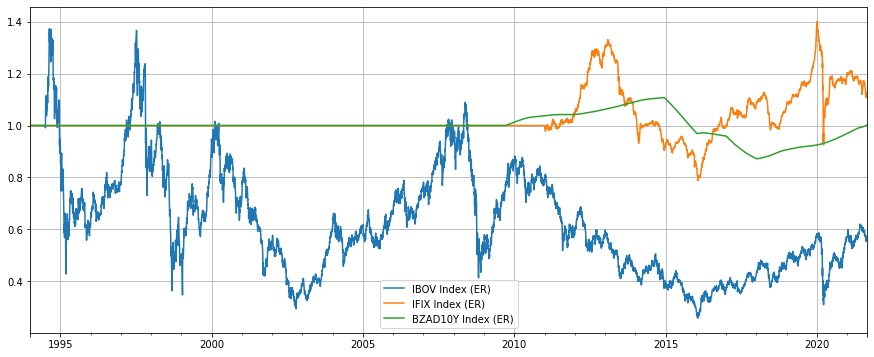

In [4]:
data[summary_statistics_bz.index].plot(figsize=(15,6),grid=True)

#### Complete period regressions

In [5]:
# Regression with only IBOV
start_date = START_DATES['IFIX Index (ER)']
all_time_series = df_brazil.loc[df_brazil.index>start_date]

model = sm.OLS(all_time_series['IFIX Index (ER)'],
               sm.add_constant(all_time_series['IBOV Index (ER)'])).fit(cov_type='HAC',cov_kwds={'maxlags':3})  
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        IFIX Index (ER)   R-squared:                       0.358
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                     18.50
Date:                Sat, 15 Jan 2022   Prob (F-statistic):           3.38e-05
Time:                        15:07:16   Log-Likelihood:                 287.57
No. Observations:                 128   AIC:                            -571.1
Df Residuals:                     126   BIC:                            -565.4
Df Model:                           1                                         
Covariance Type:                  HAC                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0017      0.002      0.718      0.473      -0.003       0.006
IBOV Index (ER)     0.2894      0.067      4.301      0.000       0.158       0.421
==============================================================================
Omnibus:                        0.940   Durbin-Watson:                   1.852
Prob(Omnibus):                  0.625   Jarque-Bera (JB):                0.522
Skew:                          -0.059   Prob(JB):                        0.770
Kurtosis:                       3.290   Cond. No.                         15.1
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 3 lags and without small sample correction
"""

In [6]:
# Regression with IBOV and Government bond
model = sm.OLS(all_time_series['IFIX Index (ER)'],
               sm.add_constant(all_time_series[['IBOV Index (ER)','BZAD10Y Index (ER)']])).fit(cov_type='HAC',cov_kwds={'maxlags':3})  
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        IFIX Index (ER)   R-squared:                       0.361
Model:                            OLS   Adj. R-squared:                  0.351
Method:                 Least Squares   F-statistic:                     9.593
Date:                Sat, 15 Jan 2022   Prob (F-statistic):           0.000133
Time:                        15:07:16   Log-Likelihood:                 287.89
No. Observations:                 128   AIC:                            -569.8
Df Residuals:                     125   BIC:                            -561.2
Df Model:                           2                                         
Covariance Type:                  HAC                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0016      0.002      0.668      0.504      -0.003       0.006
IBOV Index (ER)        0.2913      0.067      4.348      0.000       0.160       0.423
BZAD10Y Index (ER)    -0.3917      0.435     -0.899      0.368      -1.245       0.462
==============================================================================
Omnibus:                        0.847   Durbin-Watson:                   1.856
Prob(Omnibus):                  0.655   Jarque-Bera (JB):                0.439
Skew:                          -0.027   Prob(JB):                        0.803
Kurtosis:                       3.282   Cond. No.                         216.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 3 lags and without small sample correction
"""

In [7]:
# Regression with risk factors
all_time_series_ff = all_time_series.copy()
all_time_series_ff.loc[:,'MKT'] = monthly_bz_factors.loc[monthly_bz_factors.index>start_date]['Mkt-RF'].values
all_time_series_ff.loc[:,'SMB'] = monthly_bz_factors.loc[monthly_bz_factors.index>start_date]['SMB'].values
all_time_series_ff.loc[:,'HML'] = monthly_bz_factors.loc[monthly_bz_factors.index>start_date]['HML'].values
all_time_series_ff.loc[:,'MOM'] = monthly_bz_factors.loc[monthly_bz_factors.index>start_date]['Mom'].values

In [8]:
model = sm.OLS(all_time_series_ff['IFIX Index (ER)'],
               sm.add_constant(all_time_series_ff[['MKT', 'SMB', 'HML', 'MOM']])).fit(cov_type='HAC',cov_kwds={'maxlags':3})  
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        IFIX Index (ER)   R-squared:                       0.479
Model:                            OLS   Adj. R-squared:                  0.462
Method:                 Least Squares   F-statistic:                     13.44
Date:                Sat, 15 Jan 2022   Prob (F-statistic):           4.06e-09
Time:                        15:07:16   Log-Likelihood:                 300.92
No. Observations:                 128   AIC:                            -591.8
Df Residuals:                     123   BIC:                            -577.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.002      0.532      0.595      -0.003       0.006
MKT            0.3211      0.053      6.098      0.000       0.218       0.424
SMB            0.2191      0.059      3.715      0.000       0.104       0.335
HML           -0.1159      0.055     -2.112      0.035      -0.224      -0.008
MOM            0.0471      0.060      0.788      0.431      -0.070       0.164
==============================================================================
Omnibus:                        0.188   Durbin-Watson:                   1.830
Prob(Omnibus):                  0.910   Jarque-Bera (JB):                0.228
Skew:                          -0.089   Prob(JB):                        0.892
Kurtosis:                       2.896   Cond. No.                         33.7
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 3 lags and without small sample correction
"""

#### Complete period regressions with Generalized Method of Moments

In [9]:
# Regression with only IBOV
model = LinearFactorModelGMM(all_time_series['IFIX Index (ER)'],
                             all_time_series[['IBOV Index (ER)']]).fit(cov_type="kernel")
print("Betas: \n", model.params)
pvalues = model.params.copy()
pvalues.loc[:,:] = (stats.t.sf(np.abs(model.tstats), len(all_time_series)-1)*2)
print("\np-values: \n", pvalues)

         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 88
         Gradient evaluations: 19
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 88
         Gradient evaluations: 19
Betas: 
                         alpha  IBOV Index (ER)
IFIX Index (ER)  1.138412e-18         0.289421

p-values: 
                  alpha  IBOV Index (ER)
IFIX Index (ER)    1.0         0.000085


In [10]:
# Regression with only Government bond
model = LinearFactorModelGMM(all_time_series['IFIX Index (ER)'],
                             all_time_series[['BZAD10Y Index (ER)']]).fit(cov_type="kernel")
print("Betas: \n", model.params)
pvalues = model.params.copy()
pvalues.loc[:,:] = (stats.t.sf(np.abs(model.tstats), len(all_time_series)-1)*2)
print("\np-values: \n", pvalues)

         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 92
         Gradient evaluations: 20
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 92
         Gradient evaluations: 20
Betas: 
                         alpha  BZAD10Y Index (ER)
IFIX Index (ER)  2.439455e-19            -0.10233

p-values: 
                  alpha  BZAD10Y Index (ER)
IFIX Index (ER)    1.0            0.867337


#### Rolling regressions

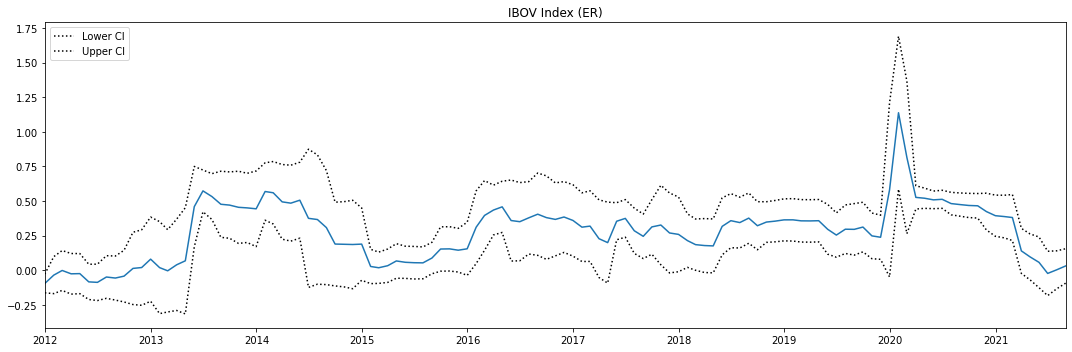

In [11]:
# Regression with only IBOV
model = RollingOLS(all_time_series['IFIX Index (ER)'],
                   all_time_series[['IBOV Index (ER)']], window=12).fit(cov_type='HAC',cov_kwds={'maxlags':3})
fig = model.plot_recursive_coefficient(figsize=(15,5))

<AxesSubplot:xlabel='DATES'>

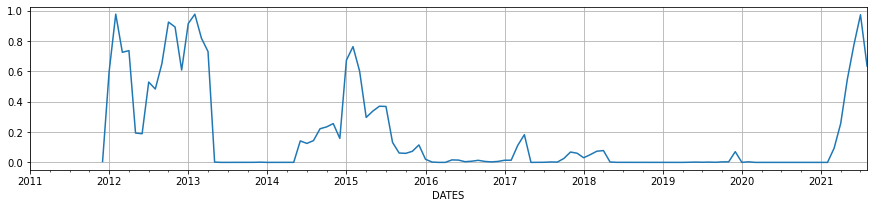

In [12]:
pd.Series([i[0] for i in list(model.pvalues)], index=model.rsquared_adj.index).plot(figsize=(15,3), grid=True)

<AxesSubplot:xlabel='DATES'>

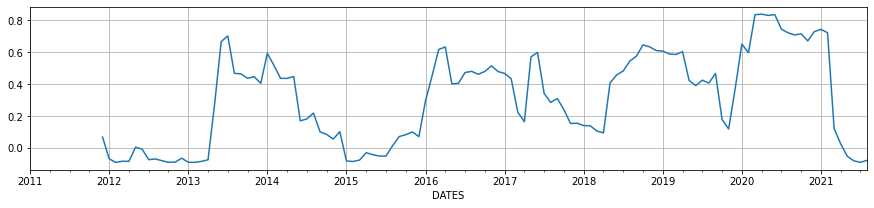

In [13]:
model.rsquared_adj.plot(figsize=(15,3), grid=True)

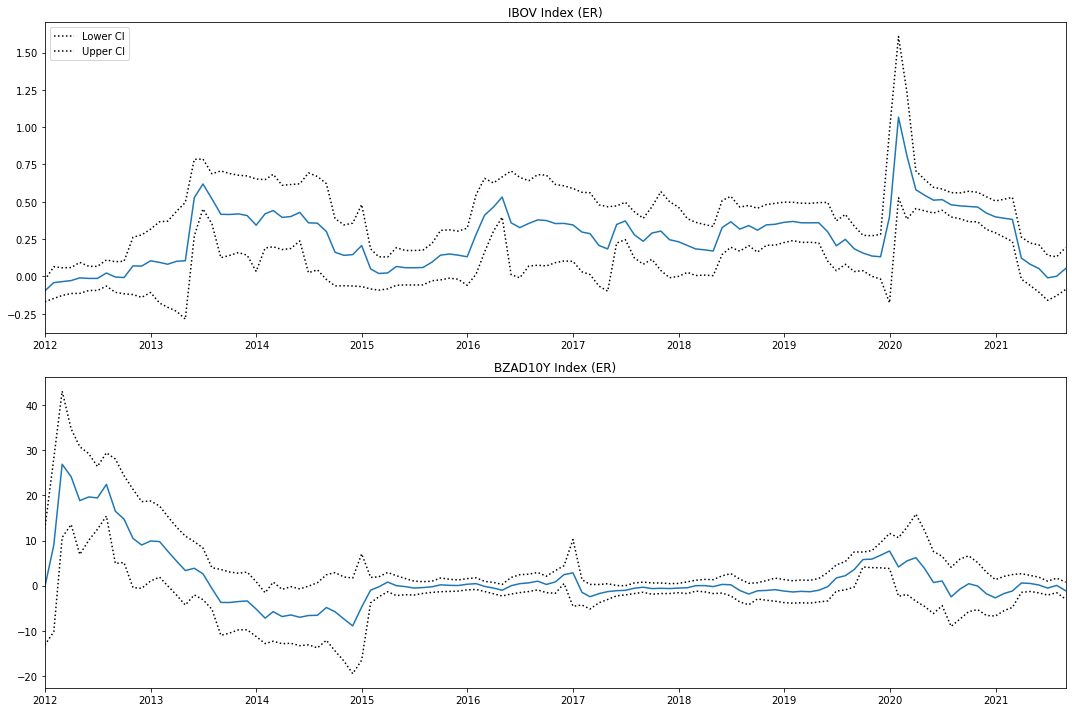

In [14]:
# Regression with IBOV and Government bond
model = RollingOLS(all_time_series['IFIX Index (ER)'],
                   all_time_series[['IBOV Index (ER)','BZAD10Y Index (ER)']], window=12).fit(cov_type='HAC',cov_kwds={'maxlags':3})
fig = model.plot_recursive_coefficient(figsize=(15,10))

<AxesSubplot:xlabel='DATES'>

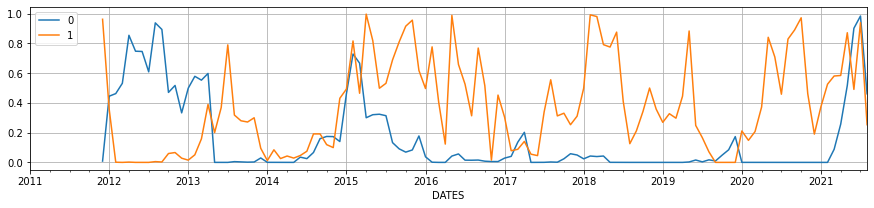

In [15]:
pd.DataFrame(model.pvalues, index=model.rsquared_adj.index).plot(figsize=(15,3), grid=True)

<AxesSubplot:xlabel='DATES'>

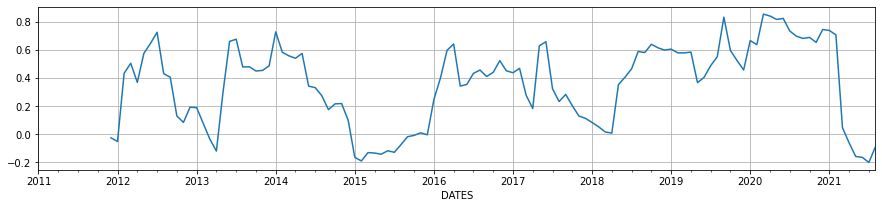

In [16]:
model.rsquared_adj.plot(figsize=(15,3), grid=True)

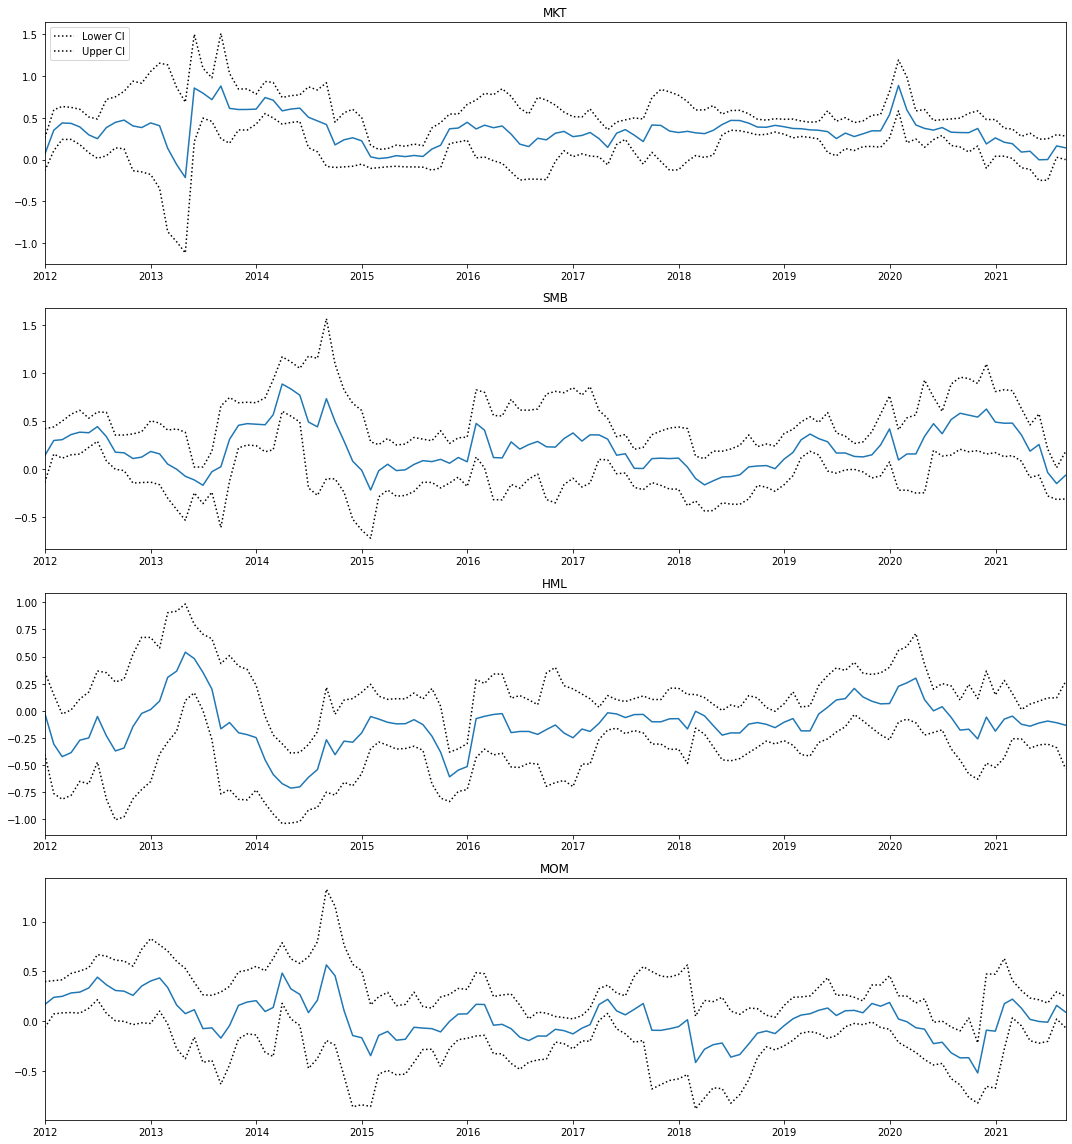

In [17]:
# Regression with Fama-French + Momentum factors
model = RollingOLS(all_time_series_ff['IFIX Index (ER)'],
                   all_time_series_ff[['MKT', 'SMB', 'HML', 'MOM']],
                   window=12).fit(cov_type='HAC',cov_kwds={'maxlags':3})
fig = model.plot_recursive_coefficient(figsize=(15,16))

<AxesSubplot:xlabel='DATES'>

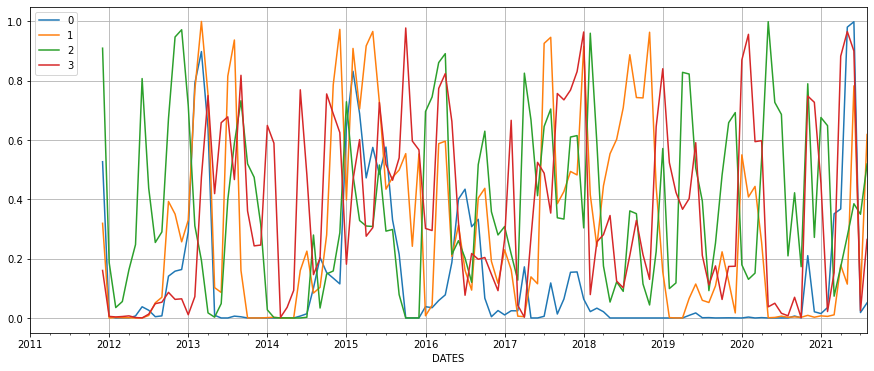

In [18]:
pd.DataFrame(model.pvalues, index=model.rsquared_adj.index).plot(figsize=(15,6), grid=True)

<AxesSubplot:xlabel='DATES'>

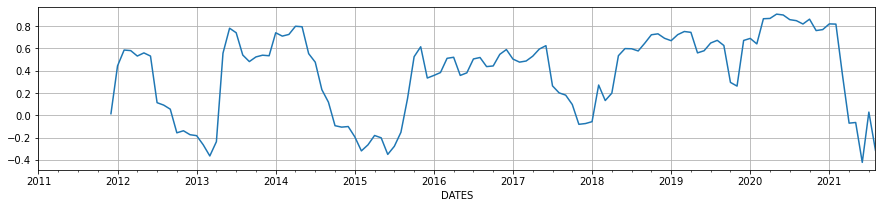

In [19]:
model.rsquared_adj.plot(figsize=(15,3), grid=True)

#### 36-month sliding window

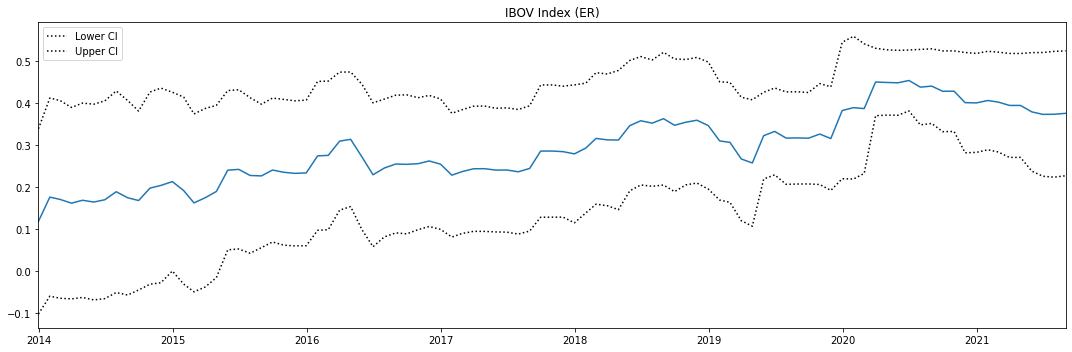

In [20]:
# Regression with only IBOV
model = RollingOLS(all_time_series['IFIX Index (ER)'],
                   all_time_series[['IBOV Index (ER)']], window=36).fit(cov_type='HAC',cov_kwds={'maxlags':3})
fig = model.plot_recursive_coefficient(figsize=(15,5))

<AxesSubplot:xlabel='DATES'>

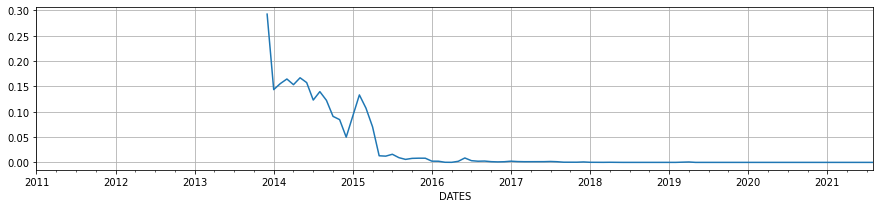

In [21]:
pd.Series([i[0] for i in list(model.pvalues)], index=model.rsquared_adj.index).plot(figsize=(15,3), grid=True)

<AxesSubplot:xlabel='DATES'>

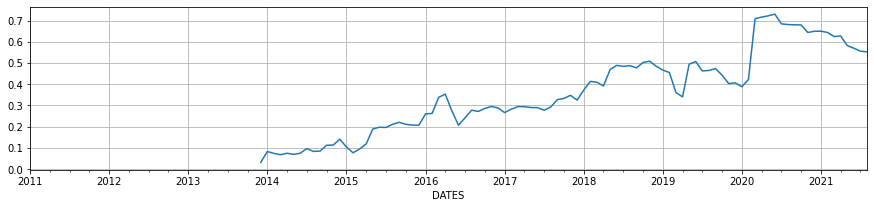

In [22]:
model.rsquared_adj.plot(figsize=(15,3), grid=True)

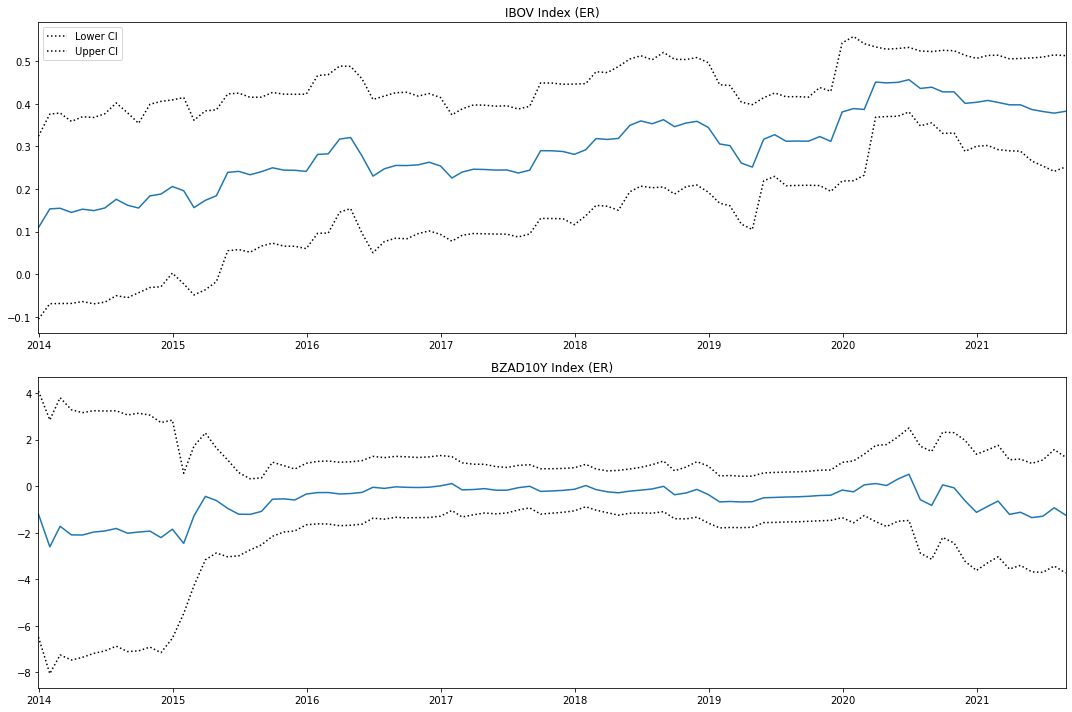

In [23]:
# Regression with IBOV and Government bond
model = RollingOLS(all_time_series['IFIX Index (ER)'],
                   all_time_series[['IBOV Index (ER)','BZAD10Y Index (ER)']], window=36).fit(cov_type='HAC',cov_kwds={'maxlags':3})
fig = model.plot_recursive_coefficient(figsize=(15,10))

<AxesSubplot:xlabel='DATES'>

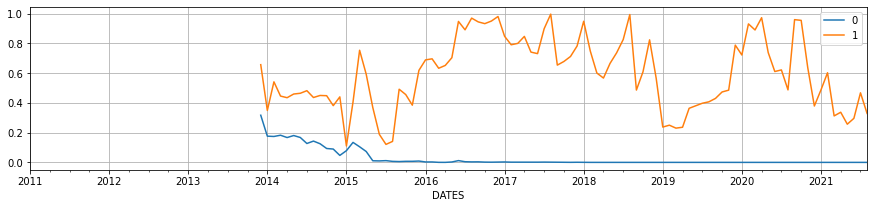

In [24]:
pd.DataFrame(model.pvalues, index=model.rsquared_adj.index).plot(figsize=(15,3), grid=True)

<AxesSubplot:xlabel='DATES'>

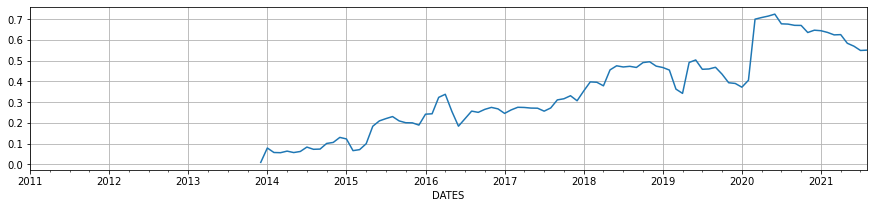

In [25]:
model.rsquared_adj.plot(figsize=(15,3), grid=True)

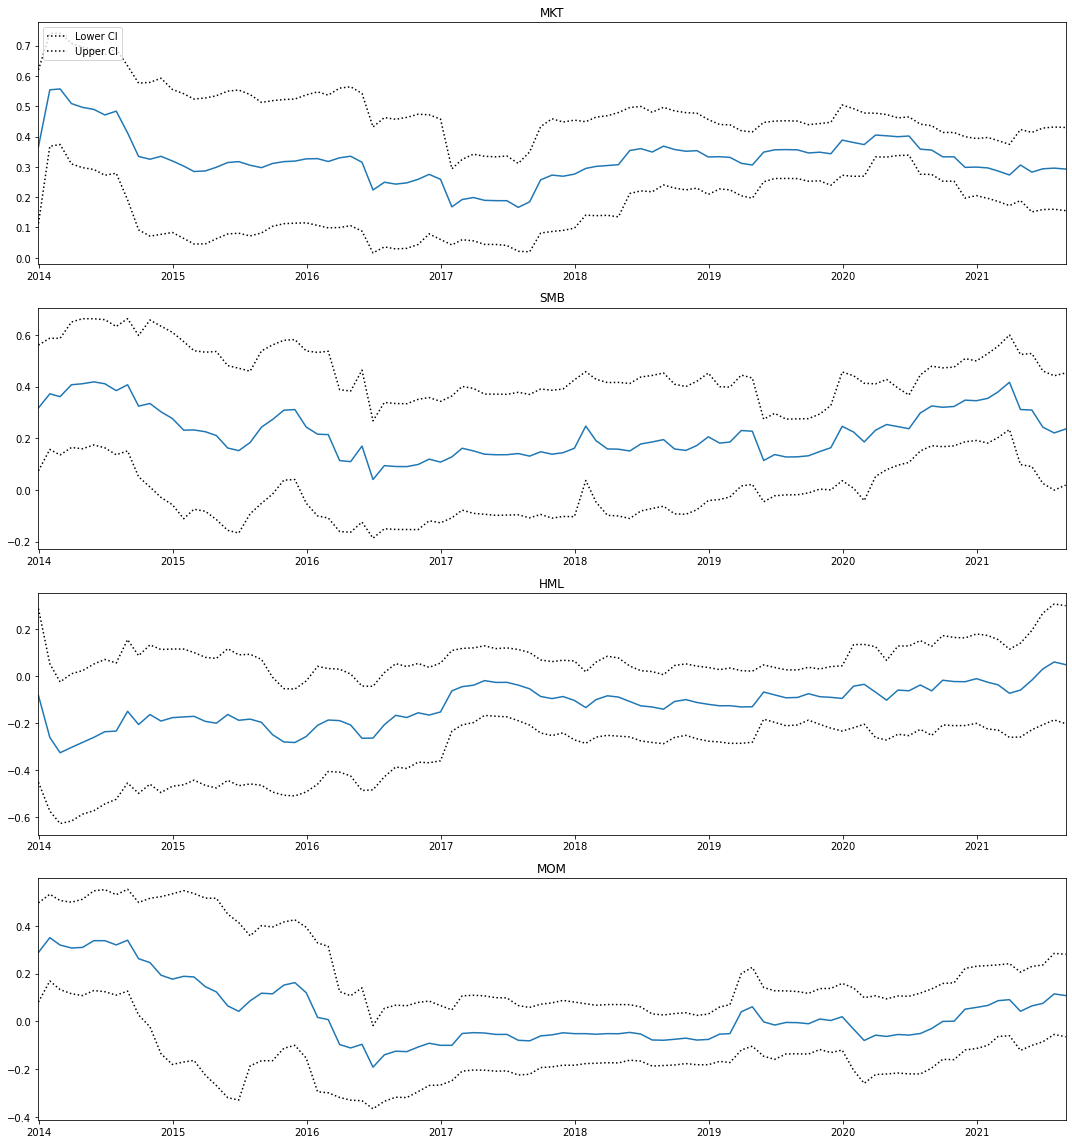

In [26]:
# Regression with Fama-French + Momentum factors
model = RollingOLS(all_time_series_ff['IFIX Index (ER)'],
                   all_time_series_ff[['MKT', 'SMB', 'HML', 'MOM']],
                   window=36).fit(cov_type='HAC',cov_kwds={'maxlags':3})
fig = model.plot_recursive_coefficient(figsize=(15,16))

<AxesSubplot:xlabel='DATES'>

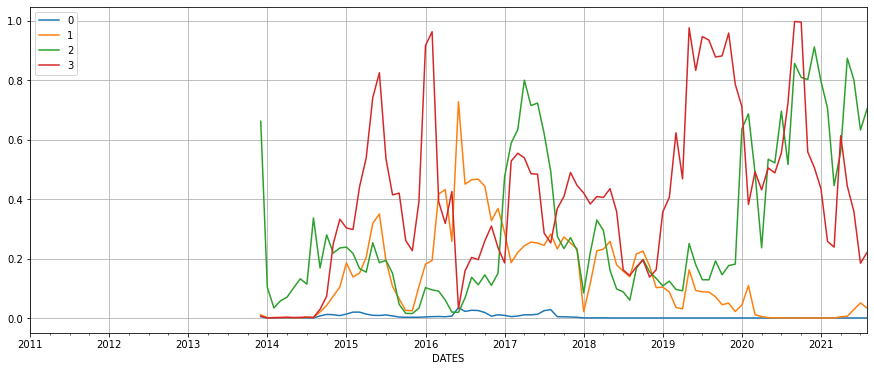

In [27]:
pd.DataFrame(model.pvalues, index=model.rsquared_adj.index).plot(figsize=(15,6), grid=True)

<AxesSubplot:xlabel='DATES'>

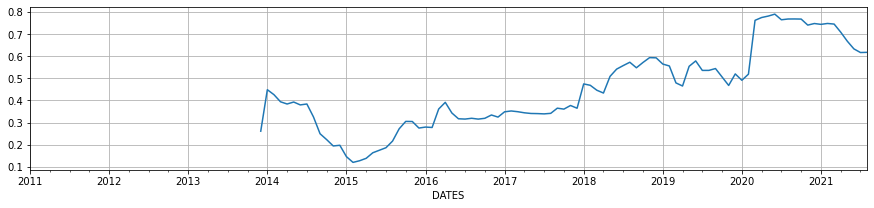

In [28]:
model.rsquared_adj.plot(figsize=(15,3), grid=True)

<AxesSubplot:xlabel='DATES'>

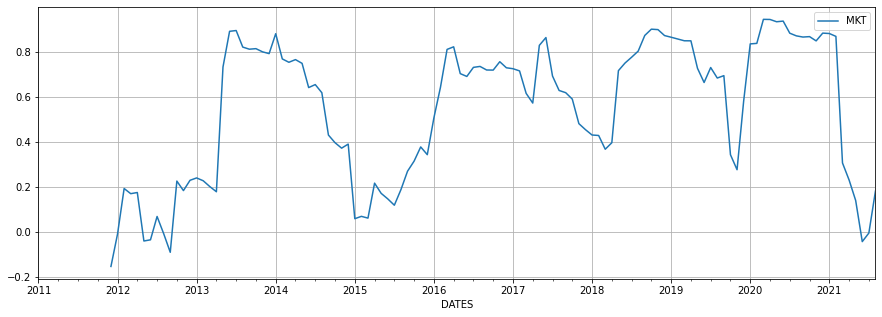

In [29]:
# Correlation between Brazilian REITs and stocks over time
mkt_corr = all_time_series_ff.copy()
corr = pd.DataFrame(
    {'MKT':mkt_corr[['IFIX Index (ER)', 'MKT']].rolling(12).corr().xs('IFIX Index (ER)', level=1, drop_level=False)['MKT'].values},
    index=mkt_corr[['IFIX Index (ER)', 'MKT']].rolling(12).corr().xs('IFIX Index (ER)', level=1, drop_level=False)['MKT'].index.get_level_values(0)
)
corr.plot(figsize=(15,5), grid=True)

#### Value strategy in Brazil

In [30]:
# Betas for positioning
rolling_params_ibov = RollingOLS(all_time_series['IFIX Index (ER)'], all_time_series[['IBOV Index (ER)']],
                                window=12).fit(cov_type='HAC',cov_kwds={'maxlags':3}).params
rolling_params_pre = RollingOLS(all_time_series['IFIX Index (ER)'], all_time_series[['BZAD10Y Index (ER)']],
                                window=12).fit(cov_type='HAC',cov_kwds={'maxlags':3}).params

# Rolling betas for value metric
rolling_params = RollingOLS(all_time_series['IFIX Index (ER)'], all_time_series[['IBOV Index (ER)', 'BZAD10Y Index (ER)']],
                            window=12).fit(cov_type='HAC',cov_kwds={'maxlags':3}).params

df_reits_value = pd.concat([rolling_params.iloc[:,:],
                            all_time_series[['IBOV Index (ER)', 'BZAD10Y Index (ER)', 'IFIX Index (ER)']]], axis=1).dropna()
df_reits_value.columns = ['Beta IBOV Index','Beta BZAD10Y Index','IBOV Index','BZAD10Y Index','IFIX Index']

df_reits_value['IFIX IndexValue'] = df_reits_value['Beta IBOV Index'] * df_reits_value['IBOV Index'] +\
                                    df_reits_value['Beta BZAD10Y Index'] * df_reits_value['BZAD10Y Index']
df_reits_value['IFIX IndexValueDiff'] = df_reits_value['IFIX IndexValue']-df_reits_value['IFIX Index']

# Data for strategy, with standard deviations on ValueDiff
upper, _, lower = ta.BBANDS(df_reits_value['IFIX IndexValueDiff'], timeperiod=4, nbdevup=1.0, nbdevdn=1.0)
upper_half, _, lower_half = ta.BBANDS(df_reits_value['IFIX IndexValueDiff'], timeperiod=4, nbdevup=0.5, nbdevdn=0.5)

# Build trade signals
df_reits_value['IFIX IndexSign'] = np.sign((df_reits_value['IFIX IndexValueDiff']))
df_reits_value.loc[(df_reits_value['IFIX IndexValueDiff']<lower),'IFIX IndexSign'] = 0
df_reits_value.loc[(df_reits_value['IFIX IndexValueDiff']>=lower)&
                   (df_reits_value['IFIX IndexValueDiff']<lower_half),'IFIX IndexSign'] = -1
df_reits_value.loc[(df_reits_value['IFIX IndexValueDiff']>=lower_half)&
                   (df_reits_value['IFIX IndexValueDiff']<upper_half),'IFIX IndexSign'] = 0
df_reits_value.loc[(df_reits_value['IFIX IndexValueDiff']>=upper_half)&
                   (df_reits_value['IFIX IndexValueDiff']<upper),'IFIX IndexSign'] = 1
df_reits_value.loc[(df_reits_value['IFIX IndexValueDiff']>upper),'IFIX IndexSign'] = 0
df_reits_value['IFIX IndexSign'] = np.sign((df_reits_value['IFIX IndexSign']).shift(1))

In [31]:
price_change = np.log(data.loc[data.index>df_reits_value.index[0],
                               ['IBOV Index (ER)','BZAD10Y Index (ER)','IFIX Index (ER)']]).diff().dropna()
value_signals = df_reits_value[['IBOV Index', 'BZAD10Y Index', 'IFIX IndexSign']].copy()
value_signals.loc[:,'IBOV Index'] = -rolling_params_ibov.dropna().shift(1).values
value_signals.loc[:,'BZAD10Y Index'] = -rolling_params_pre.dropna().shift(1).values
value_signals.loc[:,'IBOV Index'] *= df_reits_value['IFIX IndexSign'].values
value_signals.loc[:,'BZAD10Y Index'] *= df_reits_value['IFIX IndexSign'].values

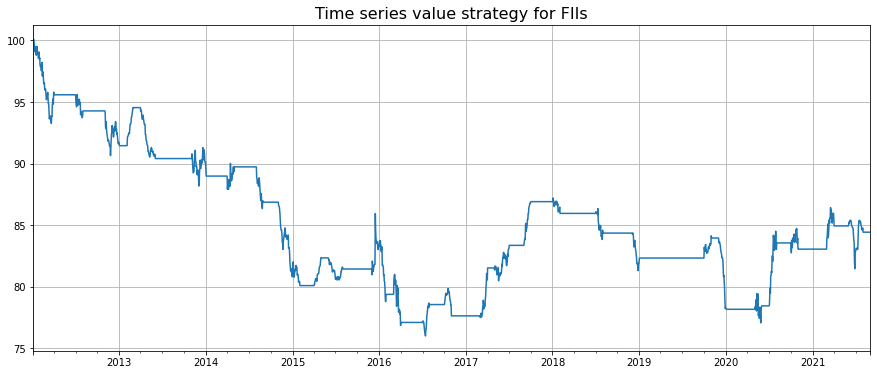

In [32]:
# initial set up, initializing the backtest with 100
backtest = pd.Series(index=price_change.index, dtype=float)
backtest.iloc[0] = 100
value_index = 0
current_index = value_signals.index[value_index]
holdings = value_signals.loc[current_index]

# loop over the next days
for i in range(1, backtest.shape[0]):
    tdy = backtest.index[i]
    
    # calculate pnl on the day
    pnl = 1 + (holdings.values * price_change.loc[tdy]).sum()
    backtest.iloc[i] = backtest.iloc[i-1] * pnl
    
    if tdy.month != current_index.month:
        value_index += 1
        current_index = value_signals.index[value_index]
        holdings = value_signals.loc[current_index]

# plotting the result
backtest.plot(figsize=(15,6), grid=True)
plt.title('Time series value strategy for FIIs', fontsize=16)
plt.show()

Min. Month: -0.06959559606176491
Max. Month: 0.05685705685001352
Mean Ann. Return: -0.01604837089193948
Ann. Volatility: 0.055595262124500174
Ann. Sharpe: -0.2886643623695975
Daily Skew: 1.5223326537017665
Monthly Skew: -0.5224614882780456
Kurtosis: 4.990661248987555


<AxesSubplot:>

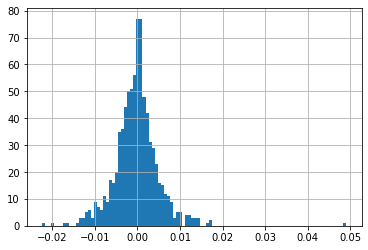

In [33]:
print('Min. Month:',(np.log(backtest.resample('M').last()).diff().min()))
print('Max. Month:',(np.log(backtest.resample('M').last()).diff().max()))
print('Mean Ann. Return:',(np.log(backtest.resample('M').last()).diff()).mean()*12)
print('Ann. Volatility:',(np.log(backtest.resample('M').last()).diff()).std()*np.sqrt(12))
print('Ann. Sharpe:',(np.log(backtest.resample('M').last()).diff()).mean()*12/((np.log(backtest.resample('M').last()).diff()).std()*np.sqrt(12)))
print('Daily Skew:',(np.log(backtest).diff()).skew())
print('Monthly Skew:',(np.log(backtest.resample('M').last()).diff()).skew())
print('Kurtosis:',(np.log(backtest.resample('M').last()).diff()).kurt())

backtest_returns = np.log(backtest).diff()
backtest_returns[backtest_returns!=0].hist(bins=100)